### Assignment 3

# Spark and Spark Streaming: Model Building

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.feature import ChiSqSelector, NGram, VectorAssembler
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import glob

In [4]:
files = glob.glob('C:/Users/user/Desktop/data/part-*')

In [5]:
df = spark.read.json(files[0])
for fp in files[1:]:
    df_temp = spark.read.json(fp)
    df = df.union(df_temp)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df_pd = df.toPandas()
df_pd['review_score']=pd.to_numeric(df_pd['review_score'])

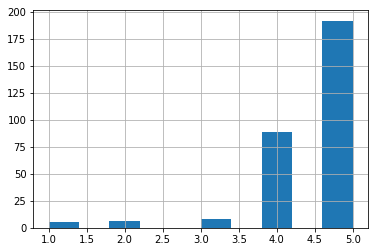

In [7]:
df_pd['review_score'].hist()

In [12]:
five = round(len(df_pd[df_pd.review_score==5])*100/len(df_pd), 2)
four = round(len(df_pd[df_pd.review_score==4])*100/len(df_pd), 2)
three = round(len(df_pd[df_pd.review_score==3])*100/len(df_pd), 2)
two = round(len(df_pd[df_pd.review_score==2])*100/len(df_pd), 2)
one = round(len(df_pd[df_pd.review_score==1])*100/len(df_pd), 2)

print("Percentage of review scores ")
print("5 = "+ str(five)+ "%")
print("4 = "+ str(four)+ "%")
print("3 = "+ str(three)+ "%")
print("2 = "+ str(two)+ "%")
print("1 = "+ str(one)+ "%")


Percentage of review scores 
5 = 64.0%
4 = 29.67%
3 = 2.67%
2 = 2.0%
1 = 1.67%


In [13]:
train, test = df.randomSplit([0.8, 0.2], seed=123)
train = train.select('review_text', 'review_score')
test = test.select('review_text', 'review_score')

After we have downloaded the data and split them into a train and a test set, we are ready to implement several routines to analyse the reviews.

### Feature Engineering

We specify three pipelines consisting of different feature building and selection techniques.


#### Pipeline 1
One gram + hashingTF 

In [14]:
tokenizer = Tokenizer(inputCol="review_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="tf")
idf1 = IDF(inputCol='tf', outputCol="features", minDocFreq=2)
indexer = StringIndexer(inputCol="review_score", outputCol="label").fit(df)
converter = IndexToString(inputCol="prediction", outputCol="predictedSCORE", labels=indexer.labels)

#### Pipeline 2
One gram + Count Vectorizer 

In [15]:
#tokenizer = Tokenizer(inputCol="review_text", outputCol="words")
#remover = StopWordsRemover(inputCol="words", outputCol="filtered")
cv2 = CountVectorizer(vocabSize=2**16, inputCol="filtered", outputCol='cv')
idf2 = IDF(inputCol='cv', outputCol="features", minDocFreq=2)
#indexer = StringIndexer(inputCol="review_score", outputCol="label").fit(df)
#converter = IndexToString(inputCol="prediction", outputCol="predictedSCORE", labels=indexer.labels)

#### Pipeline 3
bi gram + Count Vectorizer  + Chi-Squared feature selection

In [16]:
tokenizer3 = [Tokenizer(inputCol="review_text", outputCol="words")]
remover3 = [StopWordsRemover(inputCol="words", outputCol="filtered")]
bigrams = [NGram(n=i, inputCol="filtered", outputCol="{0}_grams".format(i)) for i in range(1, 3)]
cv3 = [CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i), outputCol="{0}_tf".format(i)) for i in range(1, 3)]
idf3 = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=2) for i in range(1, 3)]
assembler = [VectorAssembler(inputCols=["{0}_tfidf".format(i) for i in range(1, 3)], outputCol="rawFeatures")]
selector = [ChiSqSelector(numTopFeatures=2**10, featuresCol='rawFeatures', outputCol="features")]
indexer3 = [StringIndexer(inputCol="review_score", outputCol="label").fit(df)]
converter3 = [IndexToString(inputCol="prediction", outputCol="predictedSCORE", labels=indexer.labels)]

### Logistic Regression

We apply a multinomial Logistic Regression on top of the three different pipelines.

In [17]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

# pipeline 1
lr1_pipe = Pipeline(stages=[tokenizer, remover, hashingTF, idf1, indexer, lr, converter])
lr1_fit = lr1_pipe.fit(train)

In [18]:
# pipeline 2
lr2_pipe = Pipeline(stages=[tokenizer, remover, cv2, idf2, indexer, lr, converter])
lr2_fit = lr2_pipe.fit(train)

In [19]:
lr3 = [LogisticRegression(maxIter=10, regParam=0.01)]
# pipeline 3
lr3_pipe = Pipeline(stages= tokenizer3 + remover3 + bigrams + cv3 + idf3  + assembler + indexer3 + selector + lr3 + converter3)
lr3_fit = lr3_pipe.fit(train)

Here are displayed the performances of the Logistic Regressions in terms of accuracy on the test set.

In [20]:
lr1_res = lr1_fit.transform(test)
lr1_pred = lr1_res.select("prediction", "label")

lr2_res = lr2_fit.transform(test)
lr2_pred = lr2_res.select("prediction", "label")

lr3_res = lr3_fit.transform(test)
lr3_pred = lr3_res.select("prediction", "label")

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Logistic Regression-Pipeline 1 Test set accuracy = " + str(evaluator.evaluate(lr1_pred)))
print("Logistic Regression-Pipeline 2 Test set accuracy = " + str(evaluator.evaluate(lr2_pred)))
print("Logistic Regression-Pipeline 3 Test set accuracy = " + str(evaluator.evaluate(lr3_pred)))

Logistic Regression-Pipeline 1 Test set accuracy = 0.8
Logistic Regression-Pipeline 2 Test set accuracy = 0.8
Logistic Regression-Pipeline 3 Test set accuracy = 0.8363636363636363


### Naive Bayes

We apply a Naive Bayes classifier on top of the three different pipelines.

In [22]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# pipeline 1
nb1_pipe = Pipeline(stages=[tokenizer, remover, hashingTF, idf1, indexer, nb, converter])
nb1_fit = nb1_pipe.fit(train)

In [23]:
# pipeline 2
nb2_pipe = Pipeline(stages=[tokenizer, remover, cv2, idf2, indexer, nb, converter])
nb2_fit = nb2_pipe.fit(train)

In [24]:
nb3 = [NaiveBayes(smoothing=1.0, modelType="multinomial")]

# pipeline 3
nb3_pipe = Pipeline(stages= tokenizer3 + remover3 + bigrams + cv3 + idf3  + assembler + indexer3 + selector + nb3 + converter3)
nb3_fit = nb3_pipe.fit(train)

Here are displayed the performances of the Naive Bayes Classifier in terms of accuracy on the test set.

In [25]:
nb1_res = nb1_fit.transform(test)
nb1_pred = nb1_res.select("prediction", "label")

nb2_res = nb2_fit.transform(test)
nb2_pred = nb2_res.select("prediction", "label")

nb3_res = nb3_fit.transform(test)
nb3_pred = nb3_res.select("prediction", "label")

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Naive Bayes-Pipeline 1 Test set accuracy = " + str(evaluator.evaluate(nb1_pred)))
print("Naive Bayes-Pipeline 2 Test set accuracy = " + str(evaluator.evaluate(nb2_pred)))
print("Naive Bayes-Pipeline 3 Test set accuracy = " + str(evaluator.evaluate(nb3_pred)))

Naive Bayes-Pipeline 1 Test set accuracy = 0.8181818181818182
Naive Bayes-Pipeline 2 Test set accuracy = 0.8
Naive Bayes-Pipeline 3 Test set accuracy = 0.7090909090909091


### Random Forest

We build a Random Forest classifier on top of the three different pipelines.

In [26]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=25)

# pipeline 1
rf1_pipe = Pipeline(stages=[tokenizer, remover, hashingTF, idf1, indexer, rf, converter])
rf1_fit = rf1_pipe.fit(train)

In [27]:
# pipeline 2
rf2_pipe = Pipeline(stages=[tokenizer, remover, cv2, idf2, indexer, rf, converter])
rf2_fit = rf2_pipe.fit(train)

In [28]:
rf = [RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=25)]

# pipeline 3
rf3_pipe = Pipeline(stages= tokenizer3 + remover3 + bigrams + cv3 + idf3  + assembler + indexer3 + selector + nb3 + converter3)
rf3_fit = rf3_pipe.fit(train)

Here are displayed the performances of the Random Forests in terms of accuracy on the test set.

In [29]:
rf1_res = rf1_fit.transform(test)
rf1_pred = rf1_res.select("prediction", "label")

rf2_res = rf2_fit.transform(test)
rf2_pred = rf2_res.select("prediction", "label")

rf3_res = rf3_fit.transform(test)
rf3_pred = rf3_res.select("prediction", "label")

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Random Forest-Pipeline 1 Test set accuracy = " + str(evaluator.evaluate(rf1_pred)))
print("Random Forest-Pipeline 2 Test set accuracy = " + str(evaluator.evaluate(rf2_pred)))
print("Random Forest-Pipeline 3 Test set accuracy = " + str(evaluator.evaluate(rf3_pred)))

Random Forest-Pipeline 1 Test set accuracy = 0.6363636363636364
Random Forest-Pipeline 2 Test set accuracy = 0.7272727272727273
Random Forest-Pipeline 3 Test set accuracy = 0.7272727272727273


### Saving the Best Model

Now we are ready to save the chosen model in order to employ it on the streaming data.

In [30]:
lr3_fit.save('C:/Users/user/Desktop/spark/lr_FinalModel')